# Заметки. Анпилов Кирилл

# Библиотеки

## Установка

In [1]:
pip install lightgbm

In [2]:
pip install pyarrow # for read file .pqt

In [3]:
pip install openpyxl

In [4]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==2.0.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==2.0.3.230814
scikit-learn==1.2.2
sklearn-pandas==2.2.0


## Импорт

In [5]:
import numpy as np

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)

pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time


import warnings

# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

# Функции

In [6]:
def all_column_summary(df):
    """Для описания всех столбцов"""
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

среднее значение, медиана, стандартное отклонение, минимальное и максимальное значения.

# Задача

## Загрузка данных

For Google Colab

In [10]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/train_data.pqt")
test_df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/test_data.pqt")
restored_train = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/restored_train.pqt")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For Jupyter Notebook Colab

In [ ]:
# train_df = pd.read_parquet("../data/raw/train_data.pqt")
# test_df = pd.read_parquet("../data/raw/test_data.pqt")

Low memory

In [ ]:
# train_df = pd.read_parquet("../data/interim/train_data_lm.pqt")
# test_df = pd.read_parquet("../data/interim/test_data_lm.pqt")

In [40]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]


train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

# restored_train[cat_cols] = restored_train[cat_cols].astype("category")

## EDA (Анализ датасета)

### Объединение датасета

In [14]:
df = pd.concat([train_df, test_df], ignore_index = True)

### Описание датасета

In [12]:
len(train_df) # В train_df делиться на 3

600000

In [13]:
len(test_df) # В test_df странное колличество записей 290120 на 3 не делится (month_4, month_5, month_6)

290120

In [14]:
df.dtypes.value_counts()

float64    81
object     11
int64       1
Name: count, dtype: int64

In [ ]:
# df.info()

In [15]:
numeric_columns = df.select_dtypes(include= np.number)
num_numeric_columns = numeric_columns.shape[1]
print("Количество столбцов с типом данных int и float:", num_numeric_columns)

Количество столбцов с типом данных int и float: 82


In [16]:
all_summary_df = all_column_summary(df)
display(all_summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,id,int64,0,890120,300000,"{0: 3, 193411: 3, 193417: 3, 193416: 3, 193415..."
1,date,object,0,890120,6,"{'month_1': 200000, 'month_2': 200000, 'month_..."
2,balance_amt_avg,float64,95060,795060,613575,"{-0.15671199607667008: 7266, -0.15641139940462..."
3,balance_amt_max,float64,95060,795060,564700,"{-0.2046870733446079: 11100, -0.20491282303028..."
4,balance_amt_min,float64,95060,795060,382491,"{-0.1259950191492185: 128140, -0.1258310256067..."
5,balance_amt_day_avg,float64,95060,795060,610490,"{-0.15624833526334467: 7296, -0.15618147769744..."
6,channel_code,object,62878,827242,45,"{'channel_code_8': 152175, 'channel_code_12': ..."
7,city,object,138956,751164,8917,"{'city_0': 125034, 'city_14': 56449, 'city_21'..."
8,city_type,object,139336,750784,7931,"{'city_type_0': 670615, 'city_type_7557': 4991..."
9,index_city_code,object,481685,408435,233,"{'index_city_code_46': 14974, 'index_city_code..."


### Feature_description

In [20]:
# feature_description = pd.read_excel("../data/feature_description.xlsx")
feature_description = pd.read_excel("/content/drive/MyDrive/Alfa-hak/feature_description.xlsx")
feature_description.columns =  ['col_name', 'description', 'type']
feature_description

,col_name,description,type
0,start_cluster,Стартовый кластер клиента,category
1,balance_amt_avg,Среднемесячный остаток на счетах клиента за месяц,number
2,balance_amt_max,Максимальный остаток на счетах клиента за месяц,number
3,balance_amt_min,Минимальный остаток на счетах клиента за месяц,number
4,balance_amt_day_avg,Среднедневной остаток на счетах клиента за месяц,number
5,channel_code,"Символьный код канала продаж, через который кл...",category
6,city,Населенный пункт,category
7,city_type,Тип населенного пункта,category
8,index_city_code,Код города в почтовом индексе,category
9,ogrn_days_end_month,Количество дней с момента регистрации ОГРН до ...,number


In [21]:
df['cnt_deb_d_oper_3m'].mean()

0.8715229255864153

In [22]:
num_summary_df = num_column_summary(df)
num_summary_df

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,mean,std,min,q25,q50,q75,max,distinct_values_counts
0,id,int64,0,890120,300000,148891.57,86383.96,0.00,74176.00,148353.00,223309.25,299999.00,"{0: 3, 193411: 3, 193417: 3, 193416: 3, 193415..."
1,balance_amt_avg,float64,95060,795060,613575,-0.01,0.94,-0.16,-0.16,-0.15,-0.11,154.24,"{-0.15671199607667008: 7266, -0.15641139940462..."
2,balance_amt_max,float64,95060,795060,564700,-0.01,0.97,-0.20,-0.20,-0.19,-0.11,169.99,"{-0.2046870733446079: 11100, -0.20491282303028..."
3,balance_amt_min,float64,95060,795060,382491,-0.01,0.95,-0.13,-0.13,-0.12,-0.11,91.45,"{-0.1259950191492185: 128140, -0.1258310256067..."
4,balance_amt_day_avg,float64,95060,795060,610490,-0.01,0.93,-0.16,-0.16,-0.15,-0.11,154.72,"{-0.15624833526334467: 7296, -0.15618147769744..."
5,ogrn_days_end_month,float64,45751,844369,31,-0.00,1.00,-1.65,-0.84,-0.02,0.79,1.83,"{-0.372424978193582: 30990, -0.720809024253693..."
6,ogrn_days_end_quarter,float64,45751,844369,92,-0.00,1.00,-1.72,-0.87,-0.02,0.87,1.80,"{0.7167096009604363: 11541, 0.7554265437108607..."
7,ft_registration_date,float64,46198,843922,7262,0.01,1.01,-1.08,-0.75,-0.31,0.42,3.09,"{-1.064013776707253: 993, -1.0479946619158673:..."
8,max_founderpres,float64,496784,393336,7235,0.01,1.01,-1.15,-0.75,-0.26,0.47,3.43,"{-1.126699008457604: 342, -1.1285911686356394:..."
9,min_founderpres,float64,496784,393336,7219,0.01,1.01,-1.08,-0.76,-0.29,0.47,3.65,"{-1.0517902588217283: 436, -1.05374177716325: ..."


In [32]:
df.iloc[50:100]

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
50,16,month_3,-0.08,-0.07,-0.02,-0.08,channel_code_7,city_6622,city_type_5662,None,...,0.95,0.48,-0.17,0.55,0.41,-0.01,0.25,0.52,{α},"{α, γ}"
51,17,month_1,-0.16,-0.20,-0.13,-0.16,channel_code_9,city_38,city_type_0,None,...,0.94,0.40,-0.17,0.55,0.41,-0.20,0.25,0.37,{α},{α}
52,17,month_2,-0.16,-0.20,-0.13,-0.16,channel_code_9,city_38,city_type_0,None,...,NaN,NaN,-0.17,NaN,NaN,-0.20,NaN,NaN,{},{α}
53,17,month_3,-0.16,-0.20,-0.13,-0.16,channel_code_9,city_38,city_type_0,None,...,NaN,NaN,-0.17,NaN,NaN,-0.20,NaN,NaN,{},{α}
54,18,month_1,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,-0.17,NaN,NaN,-0.20,NaN,NaN,{},{α}
55,18,month_2,NaN,NaN,NaN,NaN,channel_code_19,city_146,city_type_0,index_city_code_90,...,NaN,NaN,-0.17,NaN,NaN,-0.20,NaN,NaN,{α},{α}
56,18,month_3,-0.16,-0.20,-0.13,-0.16,channel_code_19,city_146,city_type_0,index_city_code_90,...,NaN,NaN,-0.17,NaN,NaN,-0.20,NaN,NaN,{α},{α}
57,19,month_1,0.21,0.09,-0.07,0.21,channel_code_21,None,None,index_city_code_2,...,0.94,0.38,-0.14,0.55,0.45,-0.20,0.25,0.37,{α},{α}
58,19,month_2,0.15,0.01,-0.06,0.15,channel_code_21,None,None,index_city_code_2,...,0.94,0.38,-0.15,0.55,0.44,-0.20,0.25,0.37,{α},{α}
59,19,month_3,0.09,-0.00,-0.07,0.09,channel_code_21,None,None,index_city_code_2,...,0.94,0.38,-0.15,0.55,0.44,-0.20,0.25,0.37,{α},{α}


In [24]:
num_summary_df_with_fd = pd.merge(num_summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')
num_summary_df_with_fd

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,mean,std,min,q25,q50,q75,max,distinct_values_counts,description,type
0,id,int64,0,890120,300000,148891.57,86383.96,0.00,74176.00,148353.00,223309.25,299999.00,"{0: 3, 193411: 3, 193417: 3, 193416: 3, 193415...",NaN,NaN
1,balance_amt_avg,float64,95060,795060,613575,-0.01,0.94,-0.16,-0.16,-0.15,-0.11,154.24,"{-0.15671199607667008: 7266, -0.15641139940462...",Среднемесячный остаток на счетах клиента за месяц,number
2,balance_amt_max,float64,95060,795060,564700,-0.01,0.97,-0.20,-0.20,-0.19,-0.11,169.99,"{-0.2046870733446079: 11100, -0.20491282303028...",Максимальный остаток на счетах клиента за месяц,number
3,balance_amt_min,float64,95060,795060,382491,-0.01,0.95,-0.13,-0.13,-0.12,-0.11,91.45,"{-0.1259950191492185: 128140, -0.1258310256067...",Минимальный остаток на счетах клиента за месяц,number
4,balance_amt_day_avg,float64,95060,795060,610490,-0.01,0.93,-0.16,-0.16,-0.15,-0.11,154.72,"{-0.15624833526334467: 7296, -0.15618147769744...",Среднедневной остаток на счетах клиента за месяц,number
5,ogrn_days_end_month,float64,45751,844369,31,-0.00,1.00,-1.65,-0.84,-0.02,0.79,1.83,"{-0.372424978193582: 30990, -0.720809024253693...",Количество дней с момента регистрации ОГРН до ...,number
6,ogrn_days_end_quarter,float64,45751,844369,92,-0.00,1.00,-1.72,-0.87,-0.02,0.87,1.80,"{0.7167096009604363: 11541, 0.7554265437108607...",Количество дней с момента регистрации ОГРН до ...,number
7,ft_registration_date,float64,46198,843922,7262,0.01,1.01,-1.08,-0.75,-0.31,0.42,3.09,"{-1.064013776707253: 993, -1.0479946619158673:...",Количество дней с даты регистрации в ФНС,number
8,max_founderpres,float64,496784,393336,7235,0.01,1.01,-1.15,-0.75,-0.26,0.47,3.43,"{-1.126699008457604: 342, -1.1285911686356394:...","Количество дней, прошедших с первой даты регис...",number
9,min_founderpres,float64,496784,393336,7219,0.01,1.01,-1.08,-0.76,-0.29,0.47,3.65,"{-1.0517902588217283: 436, -1.05374177716325: ...","Количество дней, прошедших с последней даты ре...",number


In [ ]:
num_summary_df_with_fd.to_excel("../data/feature_description.2.0.xlsx")

In [ ]:
df.select_dtypes(include="number")

,id,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,max_founderpres,min_founderpres,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,0,1,1,1,1,-0,-0,2,3,3,...,1,0,1,1,1,1,1,1,0,1
1,0,1,1,2,1,-0,-0,2,3,3,...,1,0,1,0,1,1,1,1,0,1
2,0,1,1,0,1,-0,-0,2,3,3,...,1,0,1,0,1,1,1,1,0,1
3,1,-0,-0,-0,-0,0,1,0,NaN,NaN,...,1,-0,1,0,0,1,1,-0,0,0
4,1,-0,-0,-0,-0,0,1,0,NaN,NaN,...,1,-0,1,0,0,1,1,-0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0,NaN,NaN,-0,NaN,NaN,-0,NaN,NaN
890116,299998,-0,-0,-0,-0,1,-1,-1,-1,-1,...,1,-0,1,0,-0,1,0,-0,0,0
890117,299999,-0,-0,-0,-0,-1,-0,-0,-0,-0,...,1,-0,1,0,-0,1,1,-0,0,0
890118,299999,-0,-0,-0,-0,-1,-0,-0,-0,-0,...,1,-0,1,0,-0,1,1,-0,0,0


In [ ]:
df['balance_amt_avg'].describe()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast



count   795060
mean        -0
std          0
min         -0
25%         -0
50%         -0
75%         -0
max        154
Name: balance_amt_avg, dtype: float64

In [ ]:
df.select_dtypes(exclude="number").head()

,date,channel_code,city,city_type,index_city_code,ogrn_month,ogrn_year,okved,segment,start_cluster,end_cluster
0,month_1,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
1,month_2,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
2,month_3,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
3,month_1,channel_code_2,city_14,city_type_0,NaN,ogrn_month_5,ogrn_year_15,okved_5,segment_1,{other},{other}
4,month_2,channel_code_2,city_14,city_type_0,NaN,ogrn_month_5,ogrn_year_15,okved_5,segment_1,{other},{other}


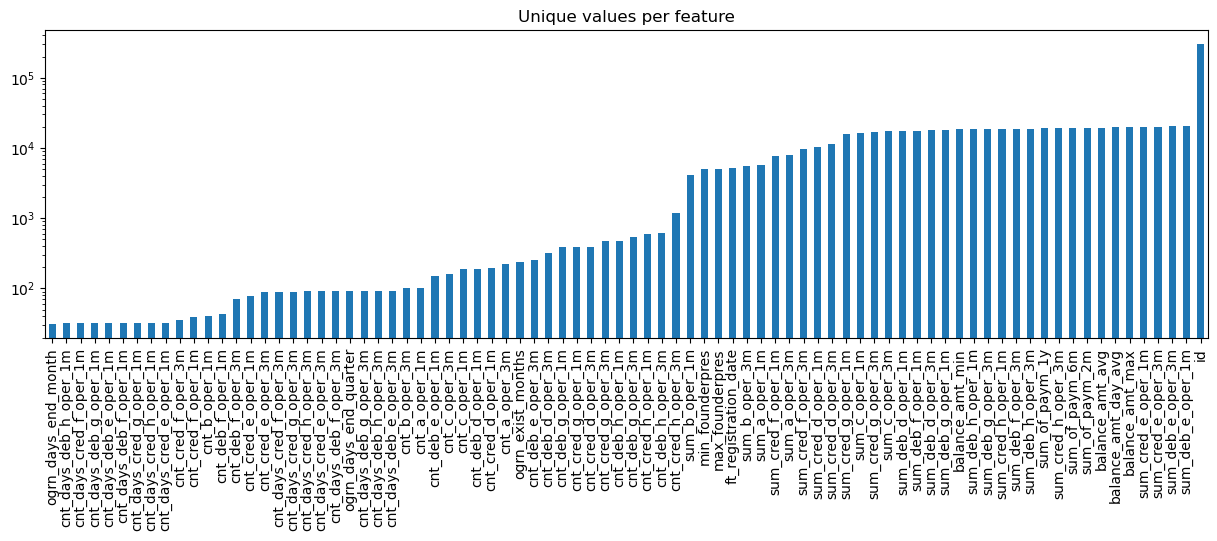

In [ ]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

In [23]:
def restore_data(df, list_of_col):
    restored_df = df.copy()

    for name_of_col in list_of_col:
      print('Столбец', name_of_col)
      # Вариант 1 - числовые значения
      if restored_df[name_of_col].dtype in [np.int64, np.float64]:
        pass

      else:
        restored_df[name_of_col] = restored_df[name_of_col].fillna(method='ffill')




    return restored_df

# Usage
restored_df = restore_data(df, list(df.columns))


Столбец id
Столбец date
Столбец balance_amt_avg
Столбец balance_amt_max
Столбец balance_amt_min
Столбец balance_amt_day_avg
Столбец channel_code
Столбец city
Столбец city_type
Столбец index_city_code
Столбец ogrn_days_end_month
Столбец ogrn_days_end_quarter
Столбец ogrn_month
Столбец ogrn_year
Столбец ft_registration_date
Столбец max_founderpres
Столбец min_founderpres
Столбец ogrn_exist_months
Столбец okved
Столбец segment
Столбец sum_of_paym_2m
Столбец sum_of_paym_6m
Столбец sum_of_paym_1y
Столбец sum_a_oper_1m
Столбец cnt_a_oper_1m
Столбец sum_b_oper_1m
Столбец cnt_b_oper_1m
Столбец sum_c_oper_1m
Столбец cnt_c_oper_1m
Столбец sum_deb_d_oper_1m
Столбец cnt_deb_d_oper_1m
Столбец sum_cred_d_oper_1m
Столбец cnt_cred_d_oper_1m
Столбец sum_deb_e_oper_1m
Столбец cnt_deb_e_oper_1m
Столбец cnt_days_deb_e_oper_1m
Столбец sum_cred_e_oper_1m
Столбец cnt_cred_e_oper_1m
Столбец cnt_days_cred_e_oper_1m
Столбец sum_deb_f_oper_1m
Столбец cnt_deb_f_oper_1m
Столбец cnt_days_deb_f_oper_1m
Столбец sum_c

In [28]:
numeric_columns = restored_df.select_dtypes(include=['number']).columns

imputer = SimpleImputer(strategy='mean')

restored_df[numeric_columns] = imputer.fit_transform(restored_df[numeric_columns])

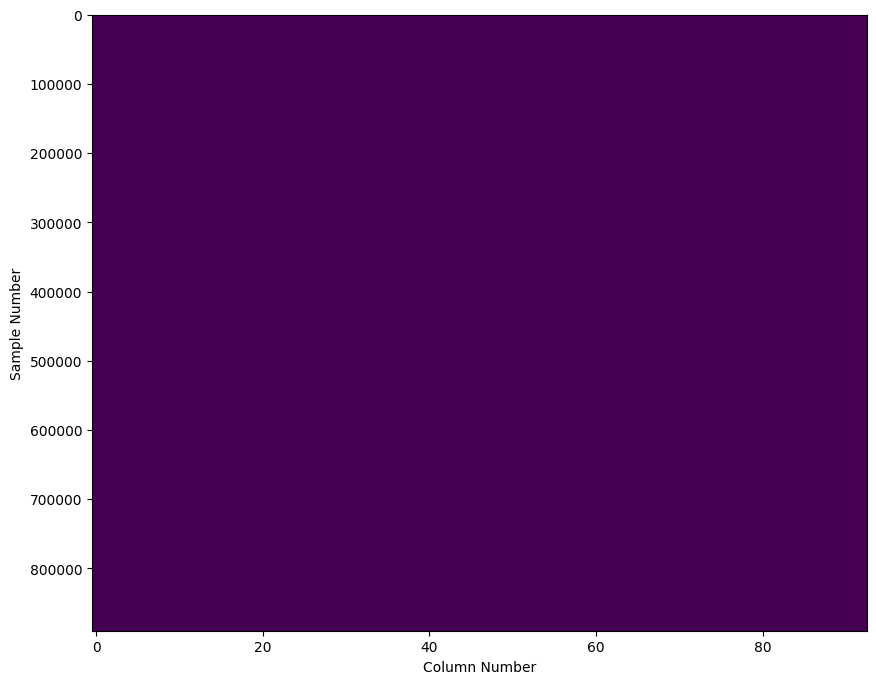

In [29]:
plt.figure(figsize=(10, 8))
plt.imshow(restored_df.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.show()

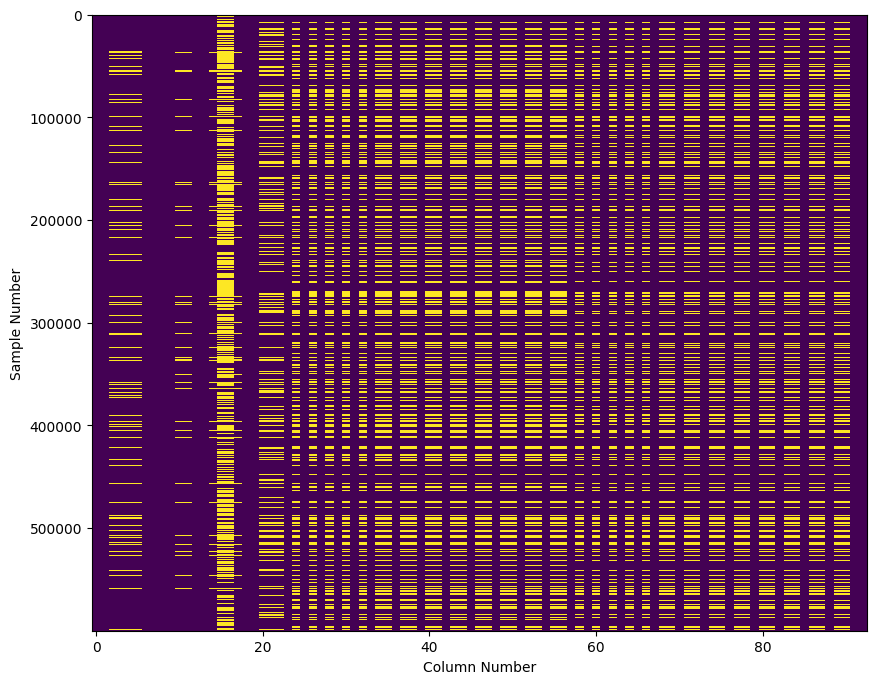

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(restored_train.isna(), aspect="auto", interpolation="nearest", cmap="viridis")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.show()

In [30]:
corr = restored_df.select_dtypes(include="number").corr().abs()

fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale='viridis',
    hoverongaps = False
))

# Настройка макета
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,
    height=800
)

fig.show()

In [ ]:
mask = (corr >= 0.8) & (corr < 1.0)

significant_correlations = corr[mask]

print("Сильно коррелирующие значения:")
print(significant_correlations)

Сильно коррелирующие значения:
                         id  balance_amt_avg  balance_amt_max  \
id                      NaN              NaN              NaN   
balance_amt_avg         NaN              NaN                1   
balance_amt_max         NaN                1              NaN   
balance_amt_min         NaN              NaN              NaN   
balance_amt_day_avg     NaN                1                1   
ogrn_days_end_month     NaN              NaN              NaN   
ogrn_days_end_quarter   NaN              NaN              NaN   
ft_registration_date    NaN              NaN              NaN   
max_founderpres         NaN              NaN              NaN   
min_founderpres         NaN              NaN              NaN   
ogrn_exist_months       NaN              NaN              NaN   
sum_of_paym_2m          NaN              NaN              NaN   
sum_of_paym_6m          NaN              NaN              NaN   
sum_of_paym_1y          NaN              NaN              N

In [ ]:
threshold = 0.7  # Установите порог корреляции здесь
high_corr_values = corr.unstack().sort_values(ascending=False)
high_corr_values = high_corr_values[(high_corr_values > threshold) & (high_corr_values < 1)]

print("Значения, которые сильно коррелируют:")
print(high_corr_values)

Значения, которые сильно коррелируют:
ogrn_exist_months     ft_registration_date   1 
ft_registration_date  ogrn_exist_months      1 
balance_amt_day_avg   balance_amt_avg        1 
balance_amt_avg       balance_amt_day_avg    1 
cnt_cred_f_oper_1m    cnt_cred_f_oper_3m     1 
                                             ..
sum_cred_h_oper_3m    sum_of_paym_1y         1 
sum_of_paym_1y        sum_deb_h_oper_3m      1 
sum_deb_h_oper_3m     sum_of_paym_1y         1 
sum_deb_f_oper_1m     sum_deb_f_oper_3m      1 
sum_deb_f_oper_3m     sum_deb_f_oper_1m      1 
Length: 202, dtype: float64


In [41]:
df["ogrn_days_end_month"]

0        -0.4886
1        -0.4886
2        -0.4886
3         0.3243
4         0.3243
           ...  
890115       NaN
890116    0.6727
890117   -1.1853
890118   -1.1853
890119   -1.1853
Name: ogrn_days_end_month, Length: 890120, dtype: float64

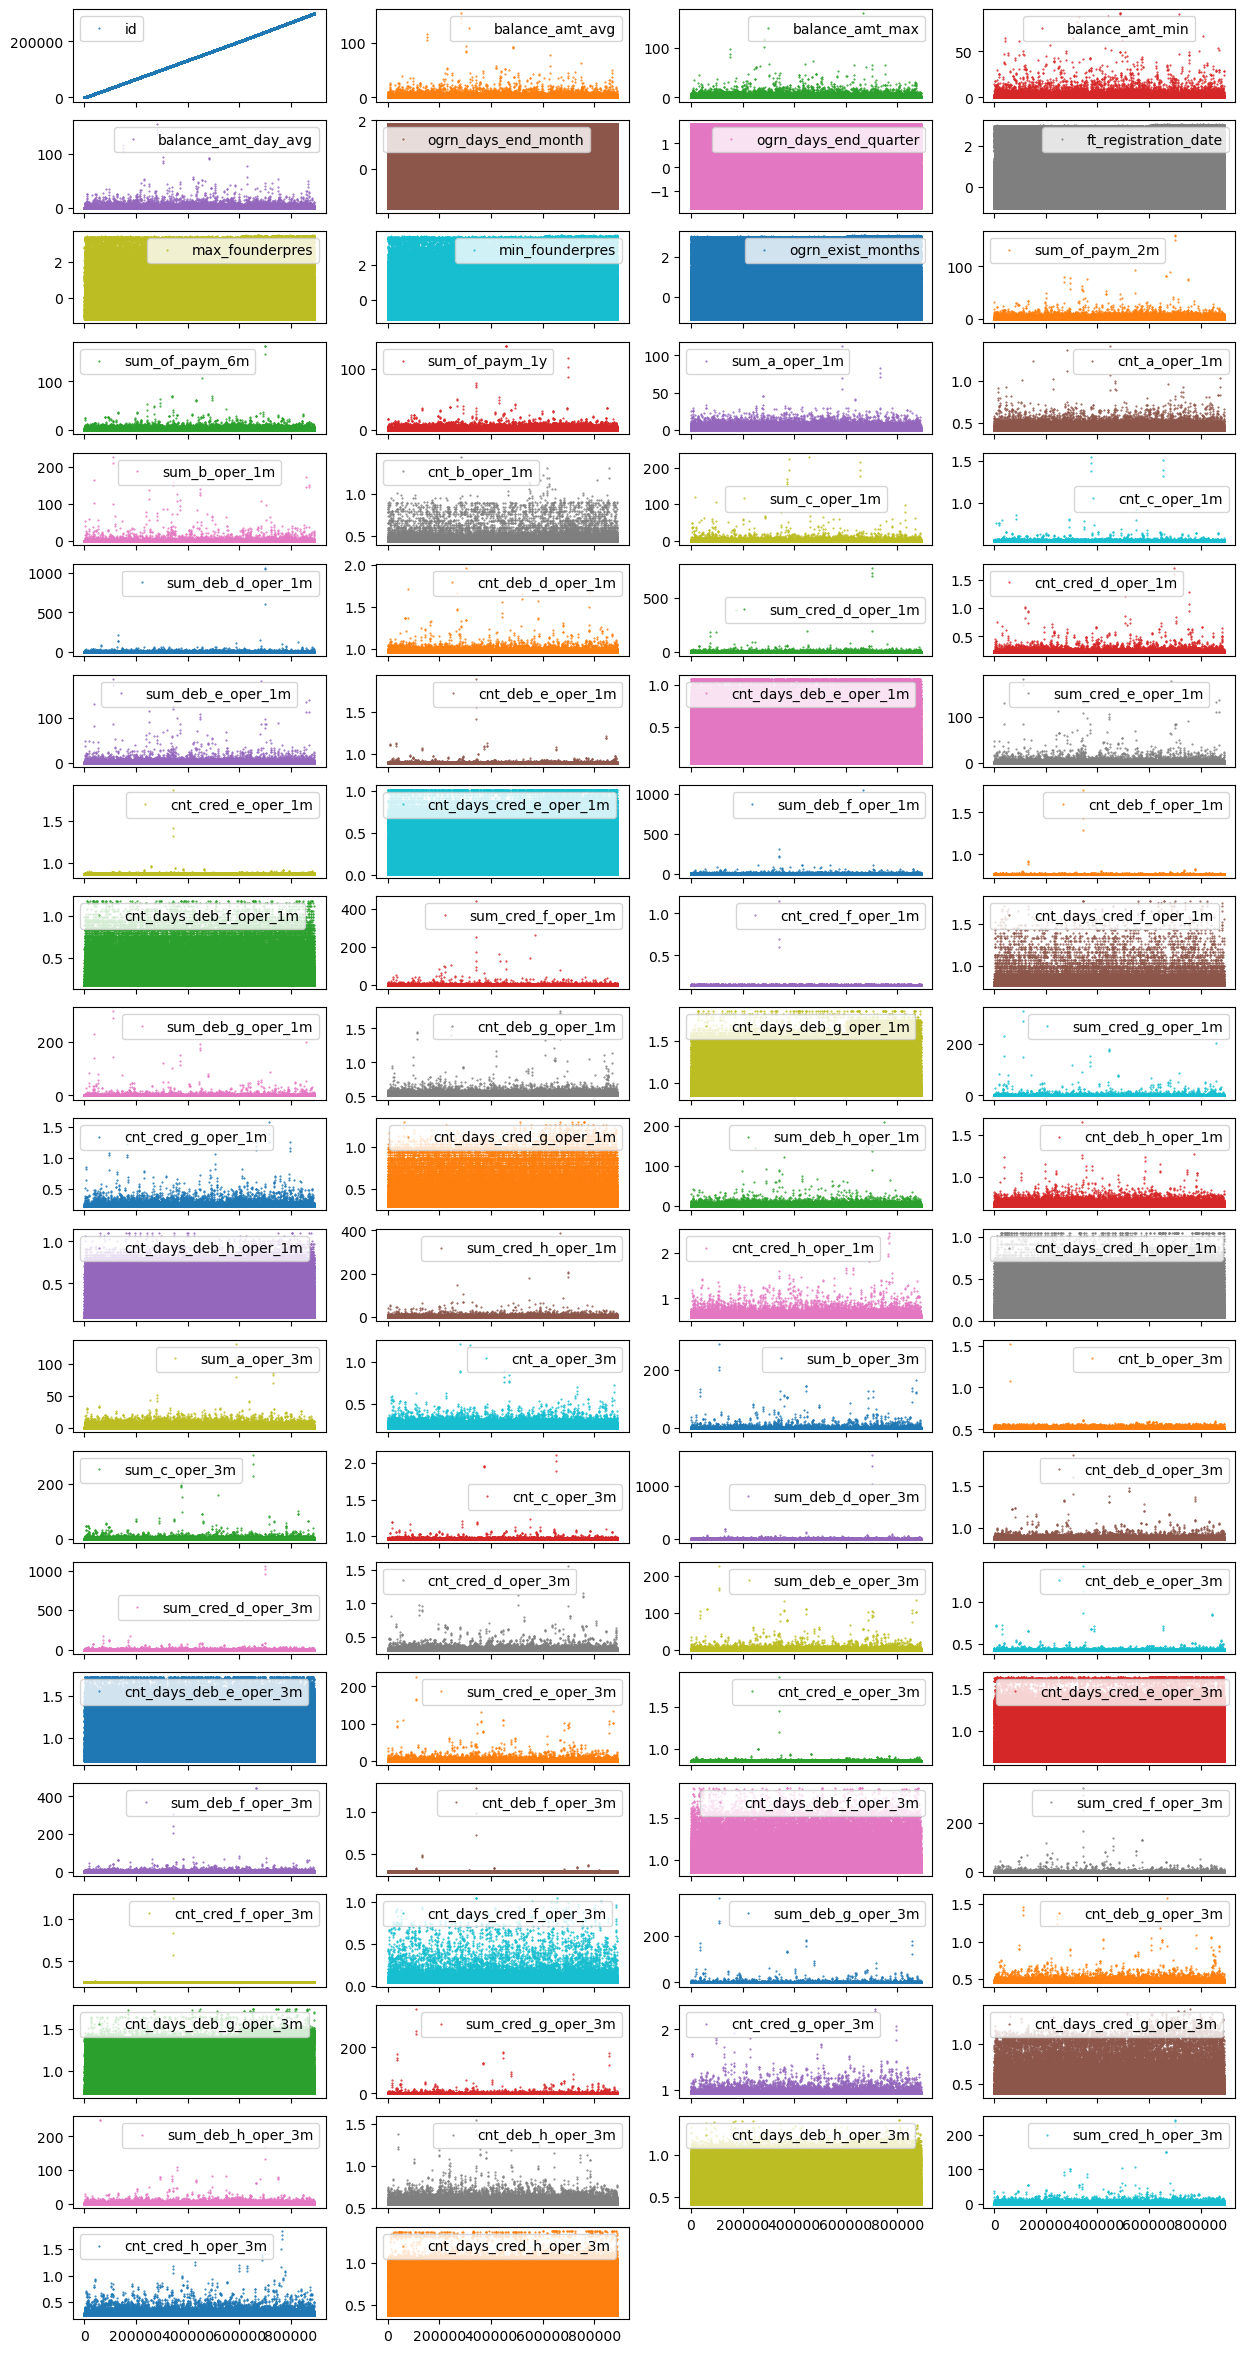

In [ ]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

In [39]:
 df['cnt_cred_f_oper_3m'].value_counts()

cnt_cred_f_oper_3m
0.2485    595858
0.2485     21588
0.2485      7968
0.2485      4984
0.2485      2844
           ...  
0.2499         1
0.2499         1
0.2496         1
0.2494         1
0.2494         1
Name: count, Length: 402, dtype: int64

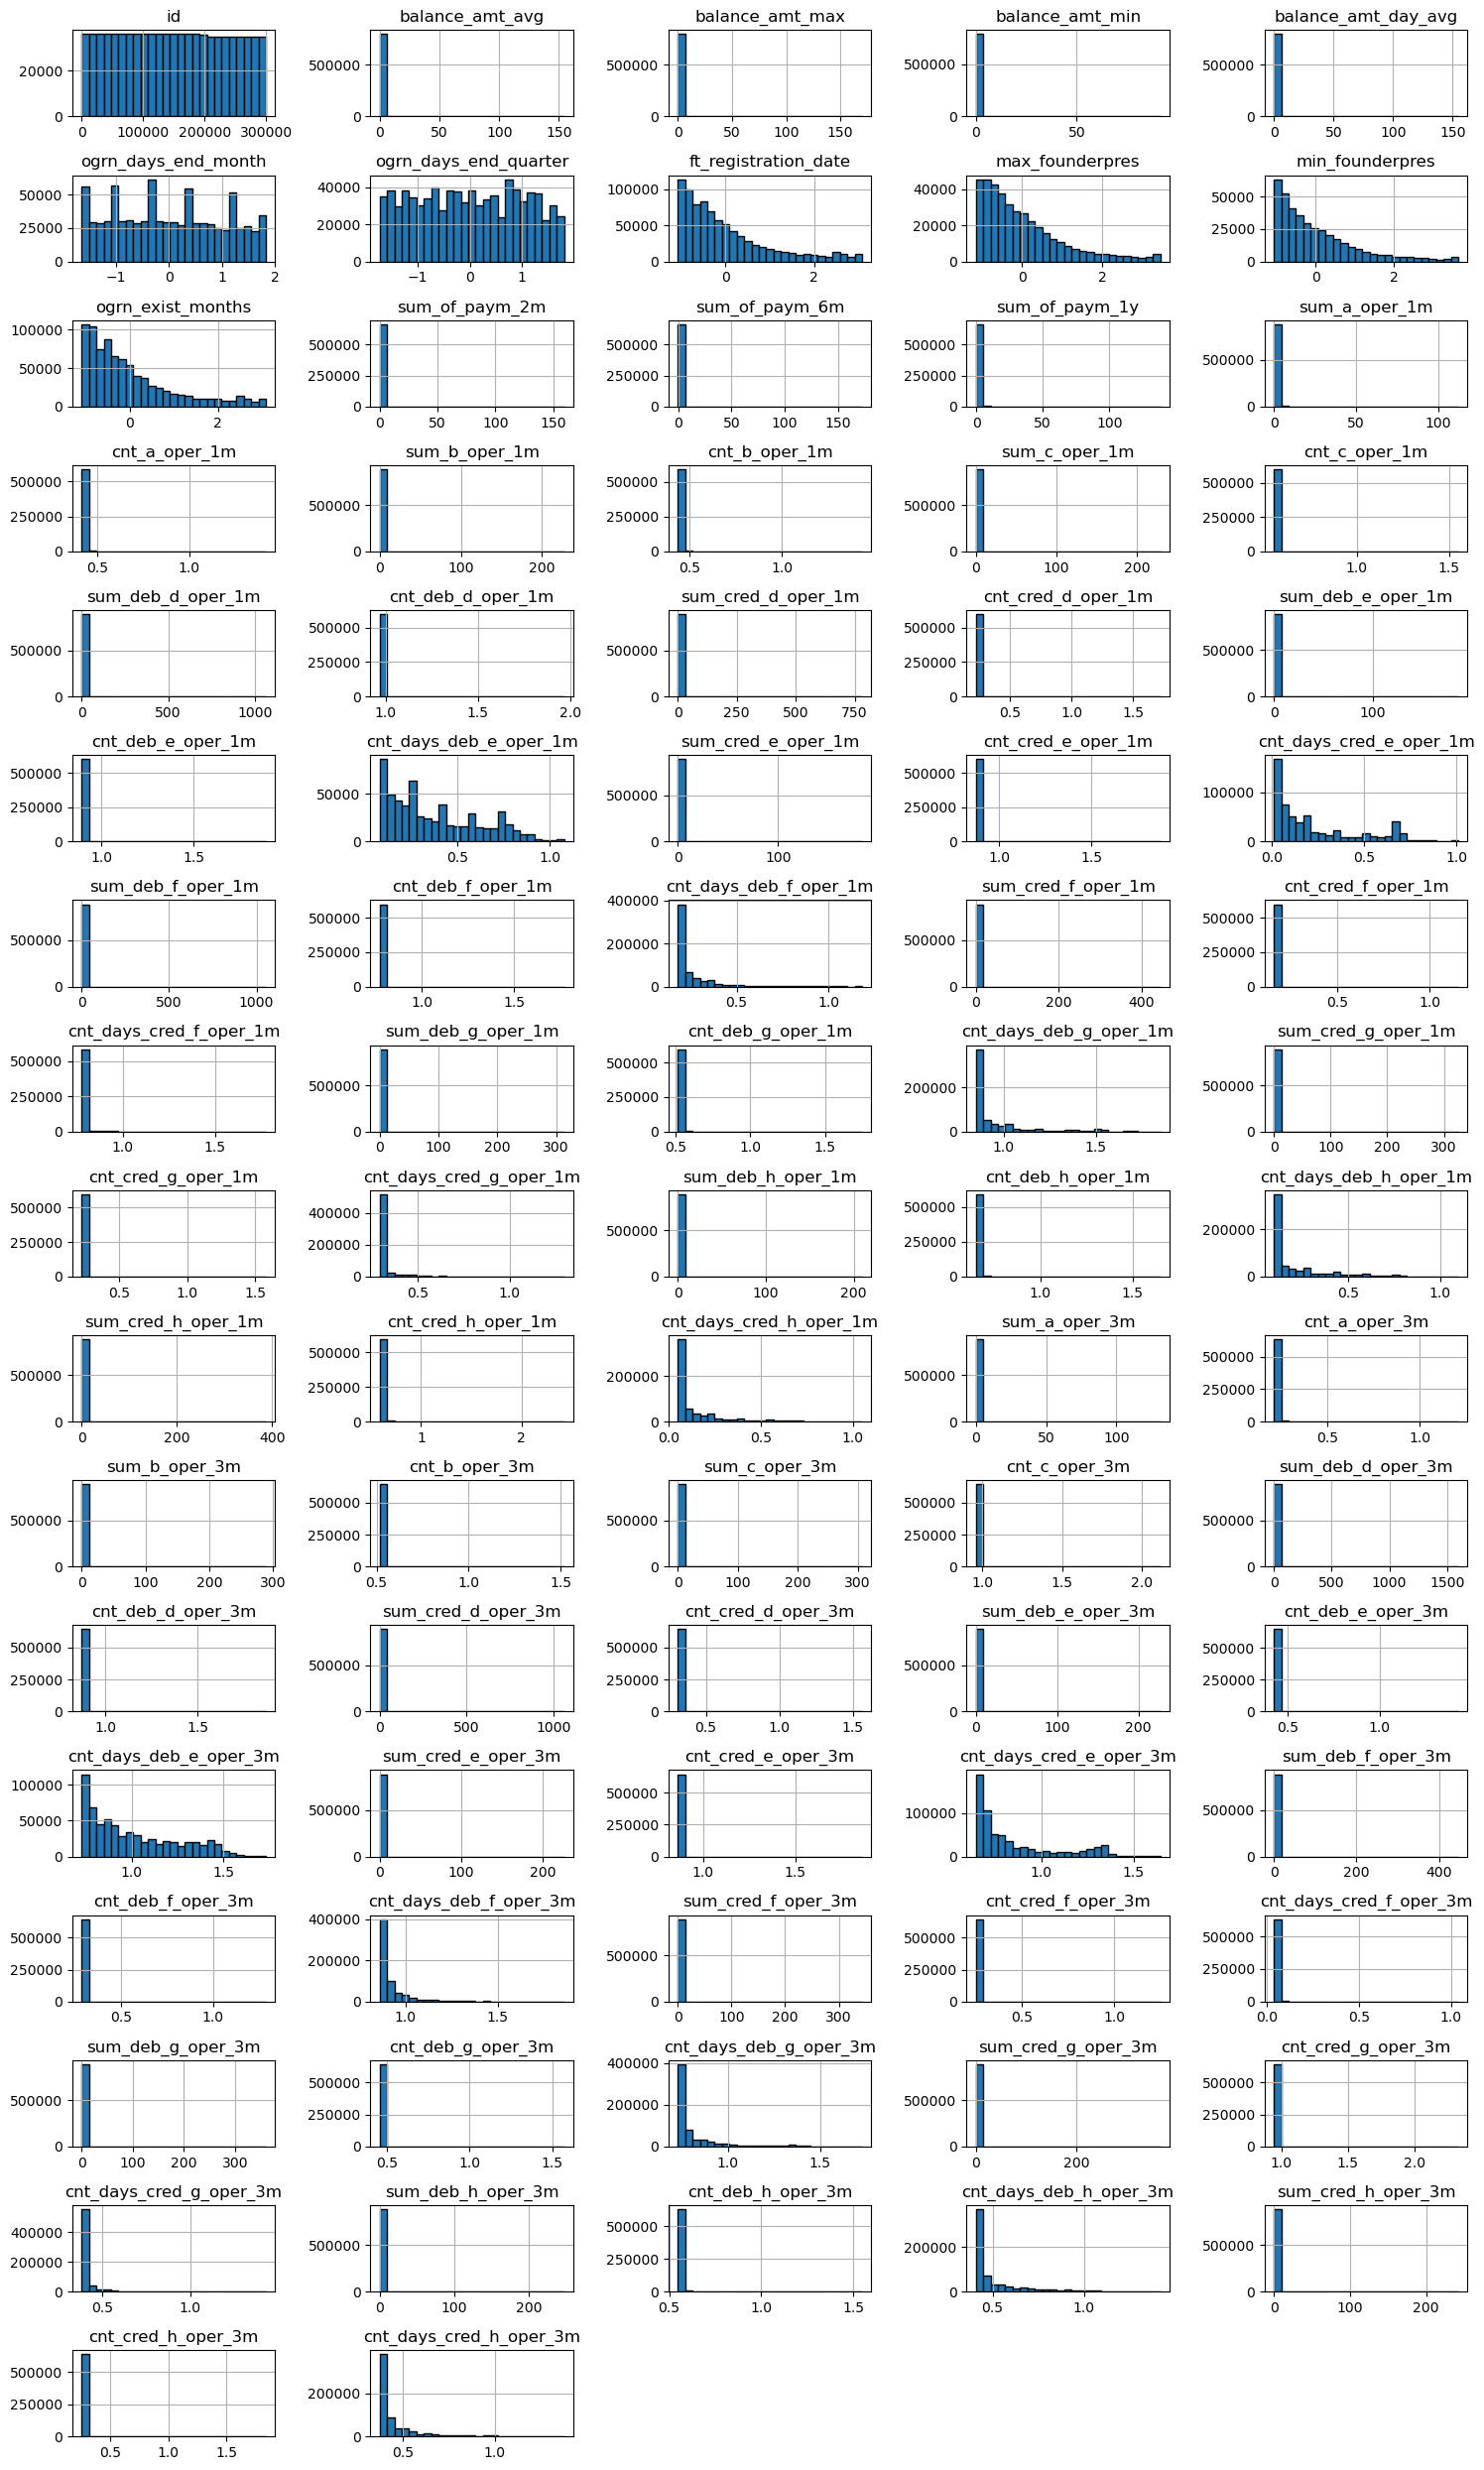

In [ ]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [ ]:
sns.pairplot(df, height=1.5, plot_kws={"s": 2, "alpha": 0.2});


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x3401c4550> (for post_execute):
Error in callback <function flush_figures at 0x3401f4820> (for post_execute):



KeyboardInterrupt



In [ ]:
df.select_dtypes(exclude="number")

,date,channel_code,city,city_type,index_city_code,ogrn_month,ogrn_year,okved,segment,start_cluster,end_cluster
0,month_1,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
1,month_2,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
2,month_3,channel_code_5,city_23,city_type_0,index_city_code_39,ogrn_month_0,ogrn_year_1,okved_30,segment_1,"{α, γ}",{other}
3,month_1,channel_code_2,city_14,city_type_0,NaN,ogrn_month_5,ogrn_year_15,okved_5,segment_1,{other},{other}
4,month_2,channel_code_2,city_14,city_type_0,NaN,ogrn_month_5,ogrn_year_15,okved_5,segment_1,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...
290115,month_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},None
290116,month_6,channel_code_9,city_25,city_type_0,index_city_code_30,ogrn_month_8,ogrn_year_11,okved_17,segment_2,NaN,None
290117,month_4,channel_code_9,city_6,city_type_0,index_city_code_34,ogrn_month_11,ogrn_year_14,okved_17,segment_3,{α},None
290118,month_5,channel_code_9,city_6,city_type_0,index_city_code_34,ogrn_month_11,ogrn_year_14,okved_17,segment_3,{α},None


In [ ]:
print(df.describe())

          id  balance_amt_avg  balance_amt_max  balance_amt_min  \
count 890120           795060           795060           795060   
mean  148892               -0               -0               -0   
std    86384                1                1                1   
min        0               -0               -0               -0   
25%    74176               -0               -0               -0   
50%   148353               -0               -0               -0   
75%   223309               -0               -0               -0   
max   299999              154              170               91   

       balance_amt_day_avg  ogrn_days_end_month  ogrn_days_end_quarter  \
count               795060               844369                 844369   
mean                    -0                   -0                     -0   
std                      1                    1                      1   
min                     -0                   -2                     -2   
25%                     -0

## Test and Train

In [ ]:
train_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,1,1,1,1,channel_code_5,city_23,city_type_0,index_city_code_39,...,1,1,1,1,1,1,0,1,"{α, γ}",{other}
1,0,month_2,1,1,2,1,channel_code_5,city_23,city_type_0,index_city_code_39,...,1,0,1,1,1,1,0,1,"{α, γ}",{other}
2,0,month_3,1,1,0,1,channel_code_5,city_23,city_type_0,index_city_code_39,...,1,0,1,1,1,1,0,1,"{α, γ}",{other}
3,1,month_1,-0,-0,-0,-0,channel_code_2,city_14,city_type_0,None,...,1,0,0,1,1,-0,0,0,{other},{other}
4,1,month_2,-0,-0,-0,-0,channel_code_2,city_14,city_type_0,None,...,1,0,0,1,1,-0,0,0,{other},{other}


In [ ]:
test_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,200000,month_4,-0,0,-0,-0,channel_code_12,city_14,city_type_0,None,...,1,0,-0,1,1,0,0,1,{α},None
1,200000,month_5,-0,-0,-0,-0,channel_code_12,city_14,city_type_0,None,...,1,0,-0,1,1,0,0,1,{α},None
2,200000,month_6,0,0,-0,0,channel_code_12,city_14,city_type_0,None,...,1,0,-0,1,1,0,0,1,None,None
3,200001,month_4,-0,-0,-0,-0,channel_code_9,city_76,city_type_0,None,...,NaN,NaN,-0,NaN,NaN,-0,NaN,NaN,{α},None
4,200001,month_5,-0,-0,-0,-0,channel_code_9,city_76,city_type_0,None,...,NaN,NaN,-0,NaN,NaN,-0,NaN,NaN,{α},None


In [34]:
train_df = restored_df.iloc[:len(train_df)]
test_df = restored_df.iloc[len(train_df):]

In [ ]:
train_df.to_parquet("../data/interim/train_data_lm.pqt")
test_df.to_parquet("../data/interim/test_data_lm.pqt")

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
x_train_filled = imputer.fit_transform(x_train)

## Подготовка к обучению

Создаем выборки для валидации и обучения

In [43]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

`n_jobs=-1` в классификаторе `LGBMClassifier` использует все доступные ядра процессора для параллельного обучения.

`verbosity`=1 для отображения информации о прогрессе обучения. Если вы хотите более детальный вывод, вы можете установить значение verbosity на большее число, например, 2 или 3.



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.: Это предупреждение указывает на то, что обнаружены категориальные признаки с количеством бинов (групп) больше, чем максимальное число бинов, настроенное в параметре max_bin. Это может произойти, если количество уникальных значений категориального признака слишком велико.

[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.: Это предупреждение указывает на то, что параметры max_bin и max_bin_by_feature могут быть проигнорированы для категориальных признаков с большим числом категорий.

In [44]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480000 entries, 501294 to 121958
Data columns (total 90 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   balance_amt_avg          480000 non-null  float64 
 1   balance_amt_max          480000 non-null  float64 
 2   balance_amt_min          480000 non-null  float64 
 3   balance_amt_day_avg      480000 non-null  float64 
 4   channel_code             480000 non-null  category
 5   city                     480000 non-null  category
 6   city_type                480000 non-null  category
 7   index_city_code          480000 non-null  category
 8   ogrn_days_end_month      480000 non-null  float64 
 9   ogrn_days_end_quarter    480000 non-null  float64 
 10  ogrn_month               480000 non-null  category
 11  ogrn_year                480000 non-null  category
 12  ft_registration_date     480000 non-null  float64 
 13  max_founderpres          480000 non-null  fl

In [45]:
start_time = time.time()
model = LGBMClassifier(verbosity=1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
end_time = time.time()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.526982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21165
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 90
[LightGBM] [Info] Start training from score -2.542774
[LightGBM] [Info] Start training from score -1.588635
[LightGBM] [Info] Start training from score -3.986612
[LightGBM] [Info] Start training from score -2.860182
[LightGBM] [Info] Start training from score -4.994823
[LightGBM] [Info] Start training from score -5.896912
[LightGBM] [Info] Start training from score -6.278036
[LightGBM] [Info] Start training from score -7.457524
[LightGBM] [Info] Start training from score -4

In [46]:
training_time = end_time - start_time
print("Время обучения модели:", training_time, "секунд")

Время обучения модели: 304.02472281455994 секунд


### Save model

In [ ]:
# dump model with pickle
with open("/models/baseline_model.pkl", "wb") as fout:
    pickle.dump(gbm, fout)

### Load model

In [ ]:
# load model with pickle to predict
with open("/models/baseline_model.pkl", "rb") as fin:
    model = pickle.load(fin)

Зададим функцию для взвешенной метрики roc auc.

Эта функция полезна при оценке качества мультиклассовых моделей классификации с учетом дисбаланса классов, позволяя учитывать важность каждого класса при вычислении ROC AUC.

In [47]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [48]:
cluster_weights = pd.read_excel("/content/drive/MyDrive/Alfa-hak/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [49]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(120000, 17)

In [50]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.737436416838452

## Прогноз на тестовой выборке

In [ ]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},NaN
200001,{α},{α},NaN
200002,{α},{α},NaN


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [ ]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission_df.shape

(100000, 18)

In [ ]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Для тестовой выборки будем использовать только последний месяц

In [ ]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [ ]:
test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

(100000, 17)

In [ ]:
test_pred_proba_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.018570,0.438989,0.001094,0.003762,0.000294,0.000116,1.297136e-07,0.0,0.000829,0.013894,0.001293,5.290471e-11,0.001651,0.0,0.000015,0.519494,0.0
1,0.195437,0.017019,0.043320,0.000162,0.005102,0.000003,6.688079e-05,0.0,0.017252,0.005322,0.015416,7.473112e-08,0.000532,0.0,0.000225,0.700143,0.0


In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)